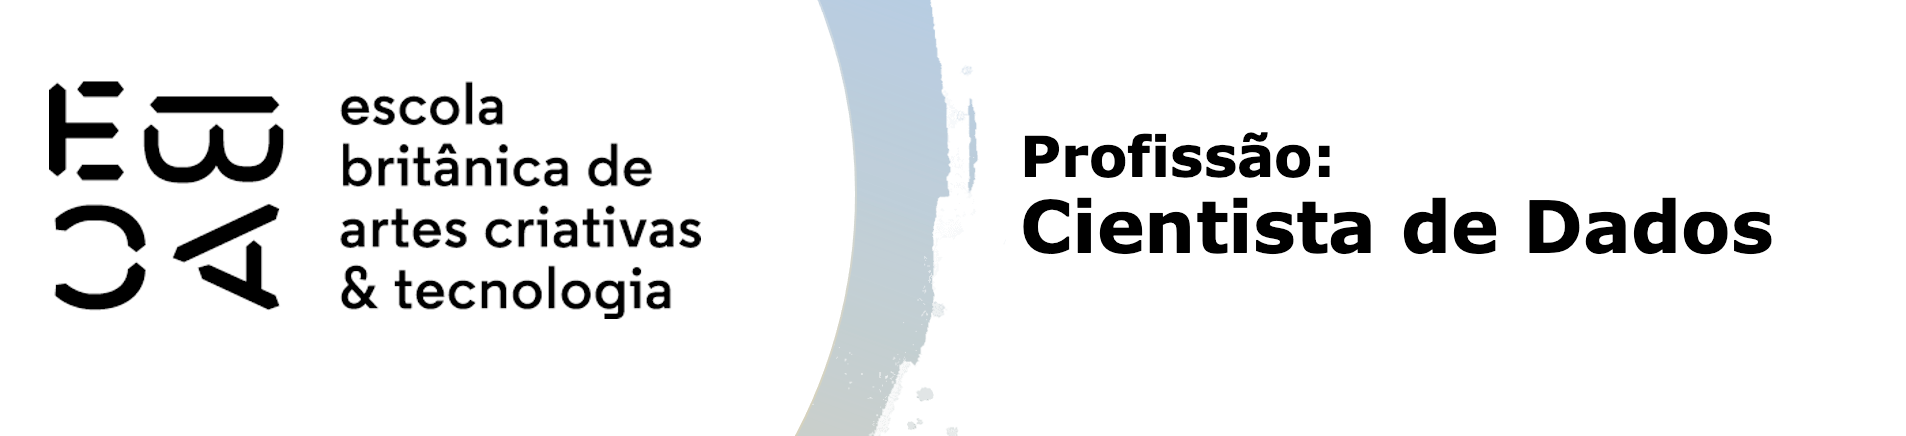

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

C:\Users\cepir\AppData\Local\Temp\ipykernel_15036\690107096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['retorno_positivo'] = df_filtrado['Retorno'] > 0


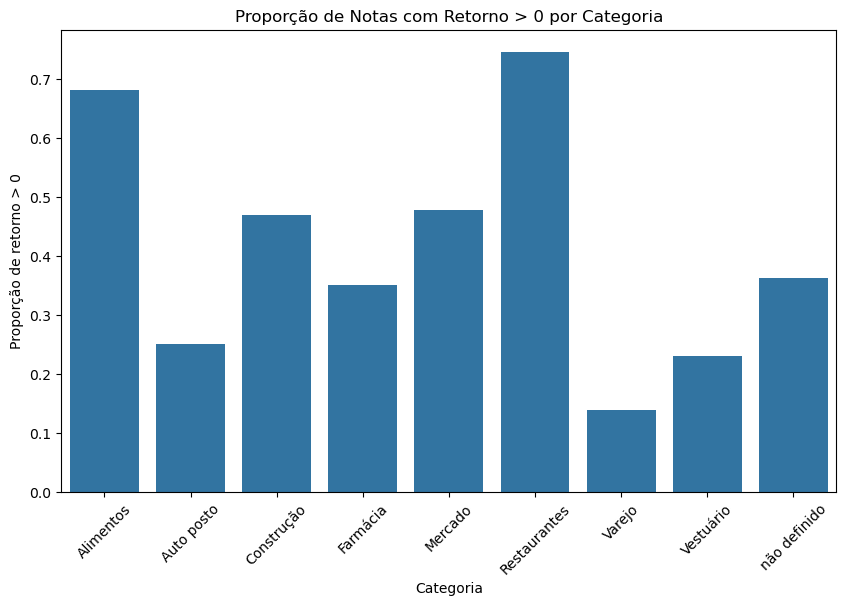

In [6]:
# filtra dados a partir de janeiro de 2020
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])
df_filtrado = df[df['Data Emissão'] >= '2020-01-01']

# cria coluna de retorno positivo
df_filtrado['retorno_positivo'] = df_filtrado['Retorno'] > 0

# calcula a proporção por categoria
proporcao = df_filtrado.groupby('categoria')['retorno_positivo'].mean().reset_index()

# plot
plt.figure(figsize=(10, 6))
sns.barplot(data=proporcao, x='categoria', y='retorno_positivo')
plt.ylabel('Proporção de retorno > 0')
plt.xlabel('Categoria')
plt.title('Proporção de Notas com Retorno > 0 por Categoria')
plt.xticks(rotation=45)
plt.show()

--> Restaurantes têm a maior proporção (acima de 0,7), ou seja, mais de 70% das notas emitidas por restaurantes tiveram retorno positivo.   
--> Varejo e Vestuário apresentam proporções menores, mostrando que menos notas tiveram retorno > 0 nesses tipos de estabelecimento.

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [11]:
# calcula os totais
total_eventos = (df_filtrado['retorno_positivo'] == True).sum()
total_nao_eventos = (df_filtrado['retorno_positivo'] == False).sum()

# agrupa por categoria para calcular as proporções
woe_table = df_filtrado.groupby('categoria')['retorno_positivo'].agg(['sum','count'])
woe_table['eventos'] = woe_table['sum']
woe_table['nao_eventos'] = woe_table['count'] - woe_table['sum']

woe_table['perc_eventos'] = woe_table['eventos'] / total_eventos
woe_table['perc_naoeventos'] = woe_table['nao_eventos'] / total_nao_eventos

# evita divisões por 0
woe_table['WOE'] = np.log((woe_table['perc_eventos'] + 1e-6) / (woe_table['perc_naoeventos'] + 1e-6))

In [14]:
# tabela
print(woe_table[['WOE']])

                   WOE
categoria             
Alimentos     1.046322
Auto posto   -0.813178
Construção    0.160359
Farmácia     -0.326925
Mercado       0.197845
Restaurantes  1.363734
Varejo       -1.543543
Vestuário    -0.918867
não definido -0.275380


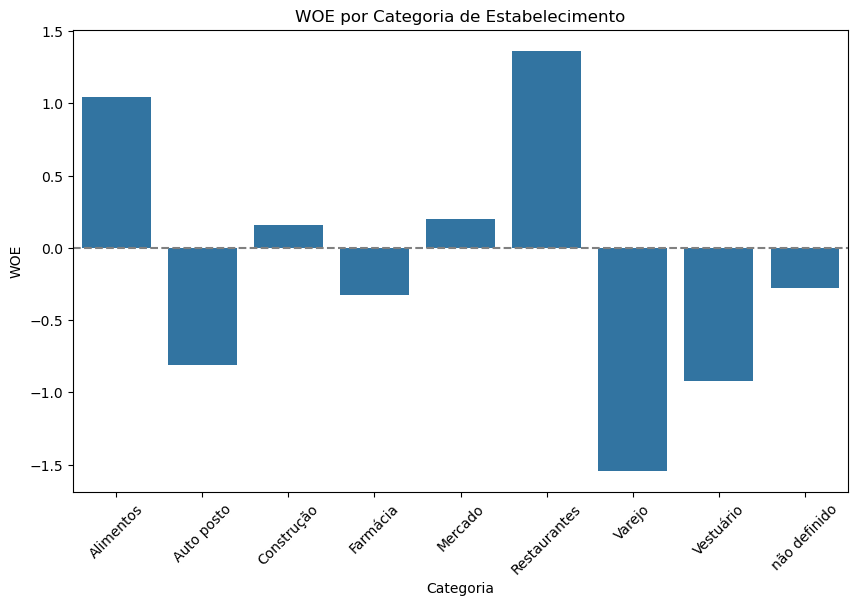

In [13]:
# gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=woe_table.reset_index(), x='categoria', y='WOE')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('WOE')
plt.xlabel('Categoria')
plt.title('WOE por Categoria de Estabelecimento')
plt.xticks(rotation=45)
plt.show()

O gráfico confirma as conclusões tiradas na análise de retorno, visto que o WOE é negativo em variáveis onde é mais frequente o "não-retorno" (ex: Varejo, Vestuário e Auto Posto).

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [15]:
woe_table['IV'] = (woe_table['perc_eventos'] - woe_table['perc_naoeventos']) * woe_table['WOE']

# soma os IVs de todas as categorias para obter o IV total da variável
iv_total = woe_table['IV'].sum()
print(f"O Information Value (IV) total da variável é: {iv_total:.4f}")

O Information Value (IV) total da variável é: 0.2788


Categorização do IV:   

IV < 0,02: Pouca ou nenhuma capacidade de separação.   
0,02 ≤ IV < 0,1: Baixa capacidade de separação.   
0,1 ≤ IV < 0,3: Capacidade média.   
0,3 ≤ IV < 0,5: Forte capacidade.   
IV ≥ 0,5: Muito forte, mas pode indicar overfitting.

## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<font color='green'>O IV = 0.2788 indica capacidade média de separação, ou seja, a variável "categoria" possui poder moderado de ajudar a identificar quando haverá retorno positivo, tornando-a útil para modelos. Ainda assim, é interessante considerar outras variáveis também para fortalecer o modelo.</font>